# Animal Shelter (XGBoost)


In [1108]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load the Animal Shelter dataset and display a sample.

In [1109]:
df = pd.read_csv("train.csv")

In [1110]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [1111]:
df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [1112]:
from sklearn.model_selection import train_test_split
import sklearn

print sklearn.__version__
# Split the dataset into Train/Test
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(df, df[["OutcomeType"]], test_size=0.2, random_state=42, stratify=df[["OutcomeType"]])

print df.shape
print X_train_df.shape
print type(X_train_df)

0.19.1
(26729, 10)
(21383, 10)
<class 'pandas.core.frame.DataFrame'>


# 1. Data  Preparation


Split the "SexuponOutcome" field into "Sex" and "Neutered".

In [1113]:
def splitSex(df):
    print "splitSex..."
    df.loc[df["SexuponOutcome"].isnull(), "SexuponOutcome"]="unknown"

    df["Sex"] = df["SexuponOutcome"].str.lower().str.contains(" male")
    df.loc[df["SexuponOutcome"].str.lower().str.contains(" male"), "Sex"] = "male"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("female"), "Sex"] = "female"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("unknown"), "Sex"] = "unknown"

    df["Neutered"] = (df["SexuponOutcome"].str.lower().str.contains("neutered")) |  (df["SexuponOutcome"].str.lower().str.contains("spayed"))
    df["Neutered"] = df["Neutered"].astype(int)


In [1114]:
def processName(df):
    print "processName..."
    
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


Clean up the breed field. Here we determine if an animal is a purebreed or a mix and create a new field encoding this information.

In [1115]:
def cleanupBreed(df):
    print "cleanupBreed..."
    
    df["PureBreed"] = ~df["Breed"].str.lower().str.contains("mix")
    df.loc[df["Breed"].str.contains("/"), "PureBreed"]=False
    df["PureBreed"] = df["PureBreed"].astype(int)
    df[["Breed", "PureBreed"]].head(10)
    
cleanupBreed(df)

cleanupBreed...


The dog breed potentially encodes information that could improve classifier predictions, such as size of dog, breed popularity, breed temperament and longevity etc. This information, however is difficult to extract from the breed. Instead we encode the breed field into a set of features that can then be used by the classifier. The breed field is transformed into features by calculating a term-document matrix taking the rows in the Breed column as the document corpus. This results in the breed words being vectorized. 

This should allow the classifier to implicitly infer information regarding the breeds which affects the outcome. For example if chihuahuas or chihuahua mixes are unpopular for adoption, any breed mentioning chihuahua should result in a lower probability of adoption in the classifier. If medium sized breeds tend to be adopted more frequently, this should also be a correlation that emerges in the classifier. 

In [1116]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

breedsVec = CountVectorizer()
pca = PCA()

def fitPCA(df):
    print "fitPCA..."
    breedsTDM = breedsVec.transform(df["Breed"])
    pca.fit(breedsTDM.toarray())
    
def preprocessBreed(df):
    print "preprocessBreed..."
    #vec = CountVectorizer()
    
    breedsVec.fit(df["Breed"])#.str.replace("Mix", "").str.replace("/", " ").str.lower())
    
    fitPCA(df)
    
    return breedsVec

def processBreed(df, doPCA=0):
    print "processBreed..."
    
    breedsTDM = breedsVec.transform(df["Breed"])#.str.replace("Mix", "").str.replace("/", " ").str.lower())
    print breedsTDM.toarray().shape
    
    if doPCA>0 :

        cumul_variance = [sum(pca.explained_variance_ratio_[:i]) for i in range(len(pca.explained_variance_ratio_))]
        print sum(pca.explained_variance_ratio_[:3])
       # print pca.explained_variance_ratio_
        #print cumul_variance

        numDims = len(cumul_variance)
        for i in range(len(cumul_variance)):
            if cumul_variance[i]>=doPCA:
                numDims = i
                break

        print "NumDims=", numDims

        reduced_dims = pca.transform(breedsTDM.toarray())
        reduced_dims = reduced_dims[:,:numDims]

        print reduced_dims.shape
        breedsdf = pd.DataFrame(reduced_dims)#breedsTDM.toarray())
        breedCols = ["Breed_"+str(i) for i in range(0, reduced_dims.shape[1]) ]
        breedsdf.columns = breedCols
        #print breedsdf.head()

        df = df.join(breedsdf)
    else:
        breedsdf = pd.DataFrame(breedsTDM.toarray())
        breedCols = ["Breed_"+breedsVec.get_feature_names()[i] for i in range(0, breedsTDM.shape[1]) ]
        breedsdf.columns = breedCols
        #print breedsdf.head()

        df = df.join(breedsdf)

    #print df.head()
    return df


#preprocessBreed(df)
#df = processBreed(df, False)
#df.head()


We define a function that translates the age fields in the dataset to days by parsing the units (year(s), month(s), week(s)). We then map the age in days to an ageBracket field so as to categories the animals as (BABY, JUVENILE, ADULT, SENIOR). Animal shelters do not allow animals to be adopted before they are weaned, therefore the "BABY" bracket should add resultion to our classifier.

In [1117]:
def getAgeInDays(ageStr):
    if pd.isnull(ageStr):
        return ageStr
    
    ageParts = ageStr.lower().split(" ")
    val = int(ageParts[0])
    units = ageParts[1]
    
    if units[-1:]=="s":
        units = units[0:-1]
    
    if units=="year":
        val = 365*val
    elif units=="month":
        val = 30*val
    elif units=="week":
        val = 7*val
    
    return val

def getAgeBracket(ageInDays):
    if ageInDays<=42:
        return "baby"
    elif ageInDays<=365:
        return "juvenile"
    elif ageInDays<=365*9:
        return "adult"
    else:
        return "senior"

    
def processAge(df):
    print "processAge..."
    
    df["AgeDays"] = df["AgeuponOutcome"].apply(getAgeInDays)
    meanAge = df[["AgeDays"]].mean()

    df.loc[df["AgeDays"].isnull(), "AgeDays"]=meanAge[0]
    df["AgeBracket"] = df["AgeDays"].apply(getAgeBracket)
    
    
#processAge(df)

Here we also take the DateTime column and we split the day into 3 hour segments. This should tell us the most likely time of day for an outcome. It looks like most adoptions as well as most transfers occur during the afternoon and early evening, peaking around 17:00 (unsurprising as it is the time most people finish their dayjob)

In [1118]:
def tsToDaySegment(ts):
    return "HR_"+str(int(ts.hour/3))
    
def processDate(df):
    print "processDate..."
    
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df["DaySegment"] = df["DateTime"].apply(tsToDaySegment)
    df["OutcomeDay"] = df["DateTime"].dt.day
    df["OutcomeMonth"] = df["DateTime"].dt.month
    df["OutcomeHour"] = df["DateTime"].dt.hour
    
#processDate(df)


Create an "IsWeekend" feature to hopefully help the classifier along.

In [1119]:
def processWeekend(df):
    print "processWeekend..."
    
    df["IsWeekend"] = df["DateTime"].apply(lambda ts: (ts.weekday()>=5))
    df["IsWeekend"] = df["IsWeekend"].astype(int)

#processWeekend(df)


Does having a name make a difference to the outcome? Yes. Having a name is much more likely to result in adoption and/or return to owner.

In [1120]:
def processName(df):
    print "processName..."
    
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


#processName(df)


We also need to simplify the color field. There are too many unique colors. We do this by splitting on "/" or " " and taking only the first word.

In [1121]:
#df["SimpleColor"] = df["Color"].apply(lambda c: c.split("/| ")[0])
def processColor(df):
    print "processColor..."
    
    df["SimpleColor"] = df["Color"].apply(lambda c: c.lower().split("/")[0].split(" ")[0])


#processColor(df)


In [1122]:
from sklearn import preprocessing
# Need to install sklearn_pandas for DataFrameMapper. This is more flexible than sklearn pipeline
# because it can perform separate operations on different columns of the dataframe.
# pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
     ("AnimalType", preprocessing.LabelBinarizer()),
     ("Sex", preprocessing.LabelBinarizer()),
     ("Neutered", preprocessing.LabelBinarizer()),
     ("PureBreed", preprocessing.LabelBinarizer()),
     ("AgeBracket", preprocessing.LabelBinarizer()),
     ("DaySegment", preprocessing.LabelBinarizer()),
     ("IsWeekend", preprocessing.LabelBinarizer()),
     ("HasName", preprocessing.LabelBinarizer()),
     ("SimpleColor", None),
], default=None, df_out=True)

labelMapper = DataFrameMapper([
    ("OutcomeType", preprocessing.LabelEncoder()),
], df_out=True)




In [1123]:
def prepareDFForPrediction(df_x, df_y=None, doPCA=False):
    df_x_c = df_x.copy()
    
    splitSex(df_x_c)
    cleanupBreed(df_x_c)
    df_x_c = processBreed(df_x_c, doPCA) 
    processAge(df_x_c)    
    processDate(df_x_c)
    processWeekend(df_x_c)
    processName(df_x_c)
    processColor(df_x_c)
    
    # Transform the independent features
    df_x_c = mapper.fit_transform(df_x_c)
    
    if df_y is not None:
        # Transform the target field
        df_y_c = labelMapper.fit_transform(df_y)
    else:
        df_y_c = None
        
    df_x_c = df_x_c.drop(["Name", "DateTime", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color", "Sex_unknown",  "AgeBracket_senior", "SimpleColor"], axis=1)

    if "AnimalID" in df_x_c.columns.values:
        df_x_c = df_x_c.drop(["AnimalID"], axis=1)
        
    if "OutcomeSubtype" in df_x_c.columns.values:
        df_x_c = df_x_c.drop(["OutcomeSubtype"], axis=1)
        
    if "OutcomeType" in df_x_c.columns.values:
        df_x_c = df_x_c.drop(["OutcomeType"], axis=1)     
   
    return df_x_c, df_y_c
    

How balanced or unbalanced are our classes?

It is clear that there is a severe inbalance in the prediction classes.

The simplest solution is to duplicate records in the minority classes, however experiments with this approach resulted in a worse classifier performance.

Instead we use SMOTE (further down) which empirically gives much better results.

In [1124]:
#outcomeCounts = df.pivot_table(index=["OutcomeType"], values=["AnimalID"], aggfunc=len)
#
#maxOutcomeCount = np.max(outcomeCounts.values.ravel())
#
#outcomes = df["OutcomeType"].unique()
#
##newrecords = pd.DataFrame(columns=df.columns)
#
#newrecords = pd.DataFrame.from_items(
#    [(name, pd.Series(data=None, dtype=series.dtype)) for name, series in df.iteritems()])
#
#for outcome in outcomes:
#    outcomeCount = outcomeCounts.loc[outcome].values[0]
#    diff = maxOutcomeCount - outcomeCount
#    
#    if diff > 0:
#        subset = pd.DataFrame(df.loc[df["OutcomeType"]==outcome,:])
#        subset = subset.iloc[np.random.randint(0, subset.index.size, size=diff)]
#        print outcome, ": added ", subset.index.size, " records"
#        newrecords = newrecords.append(subset)
#        
#print "Total records added: ", newrecords.index.size

#df = df.append(newrecords)

#sns.countplot(data=df, x="OutcomeType")

# Machine Learning Model

Prepare the dataset for learning

N.B. We will treat OutcomeType as the dependant variable. OutcomeType is directly inferable from OutcomeSubtype, however this goes contrary to the spirit of the Kaggle challenge and the Kaggle testing set does not include this field among the features, therefore in order for our learning algorithm not to be trivial, we will remove this field.

In [1125]:
print y_train_df.head()
preprocessBreed(df)
X_train_df, y_train_df = prepareDFForPrediction(X_train_df, y_train_df, doPCA=0)
X_test_df, y_test_df = prepareDFForPrediction(X_test_df, y_test_df, doPCA=0)
print X_train_df.head()

X_train = X_train_df.values
y_train = y_train_df.values

X_test = X_test_df.values
y_test = y_test_df.values

      OutcomeType
12647    Transfer
16303    Transfer
3792         Died
13021    Adoption
4295   Euthanasia
preprocessBreed...
fitPCA...
splitSex...
cleanupBreed...
processBreed...
(21383, 262)
processAge...
processDate...
processWeekend...
processName...
processColor...
splitSex...
cleanupBreed...
processBreed...
(5346, 262)
processAge...
processDate...
processWeekend...
processName...
processColor...
      AnimalType Sex_female Sex_male Neutered PureBreed AgeBracket_adult  \
12647          0          0        1        0         0                0   
16303          0          0        1        0         0                0   
3792           0          0        1        0         0                0   
13021          1          0        1        1         0                1   
4295           0          0        0        0         0                0   

      AgeBracket_baby AgeBracket_juvenile DaySegment_HR_0 DaySegment_HR_1  \
12647               1                   0               0   

Define a function to plot Receiver Operating Characteristic curves for the outcome class labels.

In [1126]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plotROCCurves(classes, classlabels, y_test_bin, y_test_proba):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0, len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    print int(np.ceil(float(len(classes))/2)), 2
    f, plts = plt.subplots(int(np.ceil(float(len(classes))/2)), 2, figsize=(10, 10))

    plts = plts.ravel()
    lw = 2

    #classlabels=labelMapper.features[0][1].inverse_transform(classes)

    for cls in range(0, len(plts)):#range(0, clf2.n_classes_):
        #plt.subplot(3,2,cls+1)
        if (cls < len(classes)):
            plts[cls].plot(fpr[cls], tpr[cls], color='darkorange',
                     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
            plts[cls].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plts[cls].set_xlim([0.0, 1.0])
            plts[cls].set_ylim([0.0, 1.05])
            plts[cls].set_xlabel('False Positive Rate')
            plts[cls].set_ylabel('True Positive Rate')
            plts[cls].set_title('ROC curve - '+classlabels[cls]+"(AUC = " + str(round(roc_auc[cls], 2))+ ")")
            plt.legend(loc="lower right")
        else:
            plts[cls].axis("off")

    f.subplots_adjust(hspace=0.4)
    plt.show()
    


The XGBoost classifier, similar to RandomForest, has a feature importance/selection feature which we use here to perform feature reduction on our dataset.

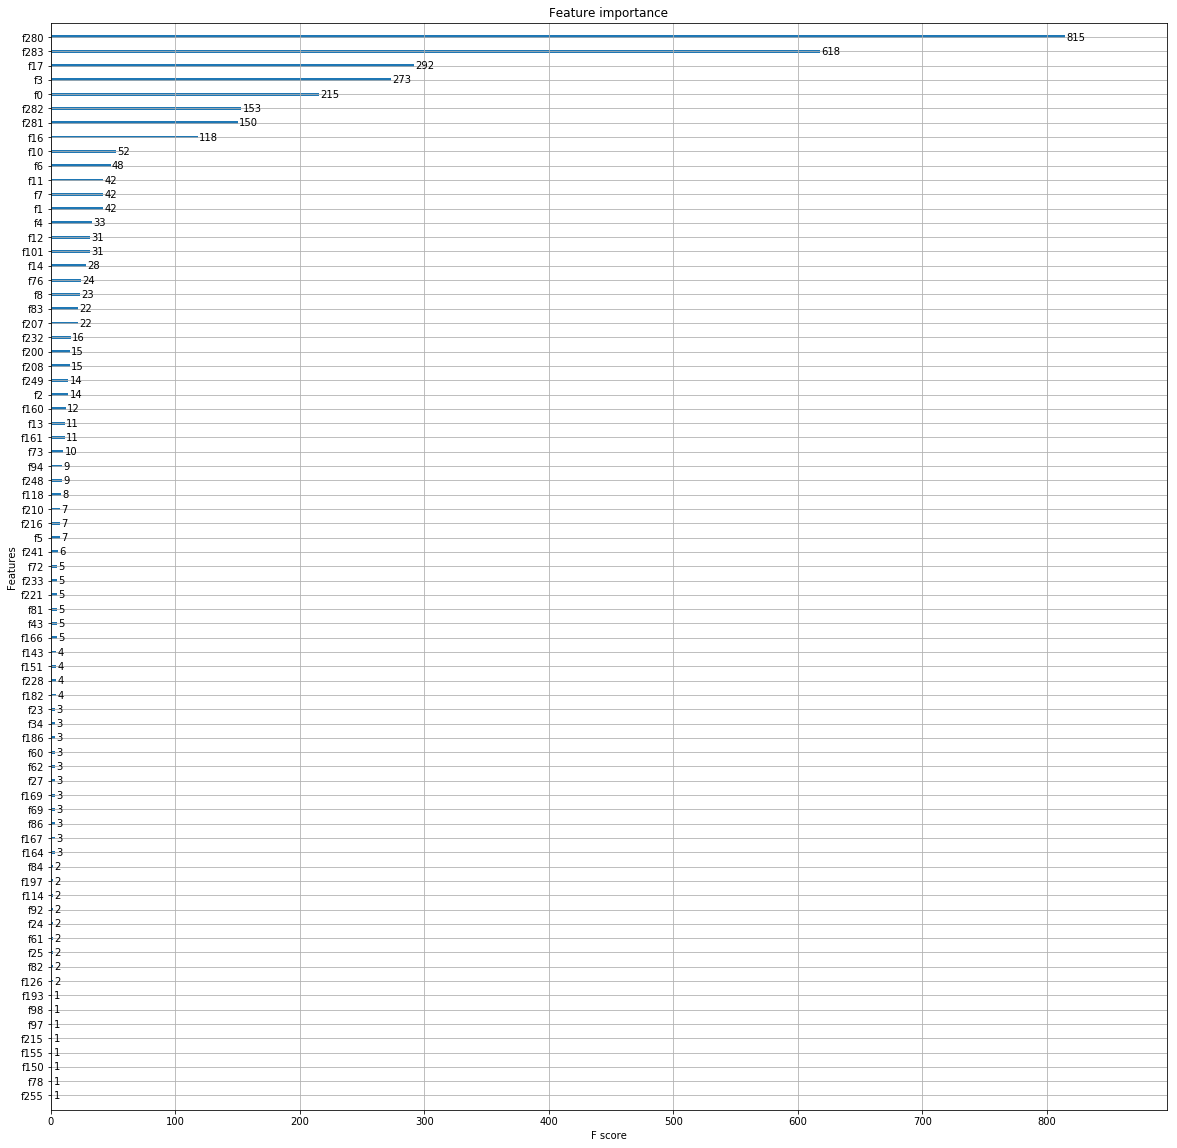

Threshold= 1e-05 : Re-fitting with  75  features instead of  284
f1 score(cv)= [ 0.66042921  0.65695803  0.65488217]
log loss(cv)= [-0.79082602 -0.79103874 -0.79338941]
f1 score(test)= 0.651557228717
log loss(test)= 0.803233779304
Threshold= 2.78255940221e-05 : Re-fitting with  75  features instead of  284
f1 score(cv)= [ 0.6574363   0.65050016  0.65416996]
log loss(cv)= [-0.78652671 -0.80024607 -0.79263131]
f1 score(test)= 0.651557228717
log loss(test)= 0.803233779304
Threshold= 7.74263682681e-05 : Re-fitting with  75  features instead of  284
f1 score(cv)= [ 0.65351594  0.66093344  0.6512581 ]
log loss(cv)= [-0.80231303 -0.78423517 -0.79667015]
f1 score(test)= 0.651557228717
log loss(test)= 0.803233779304
Threshold= 0.000215443469003 : Re-fitting with  75  features instead of  284
f1 score(cv)= [ 0.65131327  0.65632152  0.65896587]
log loss(cv)= [-0.79714575 -0.7936436  -0.78768988]
f1 score(test)= 0.651557228717
log loss(test)= 0.803233779304
Threshold= 0.000599484250319 : Re-fittin

In [1101]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

# Define an instance of XGBoost and fir the training set to it
fselGB = xgb.XGBClassifier(n_jobs=4)
fselGB.fit(X_train, y_train[:,0])

# Plot feature importances visually
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(fselGB, ax=ax)
plt.show()

# In order to determine which features tp select for our model, we iterate on a threshold value.
# Any feature with an importance value smaller than the threshold is removed and the model performance
# is determined in terms of f1 score and log loss. 
# In this way we determine the threshold value at which the performance is maximised and hence which features
# to include in our model.
thresholds_for_test = np.geomspace(0.00001, 0.1, 10, endpoint=True)
f1scorescv=[]
loglossescv=[]
f1scorestest=[]
loglossestest=[]
paramsleft=[]
for thresh in thresholds_for_test:
    support = fselGB.feature_importances_>thresh
    print "Threshold=", thresh, ": Re-fitting with ", np.sum(support), " features instead of ", len(support)
    
    GB2 = xgb.XGBClassifier(n_jobs=4)

    
    stcv = StratifiedKFold(y_train[:,0],n_folds=3,shuffle=True)
    loglosscv = cross_val_score(GB2, X_train[:,support], y_train[:,0], cv=stcv, scoring="neg_log_loss")
    f1cv = cross_val_score(GB2, X_train[:,support], y_train[:,0], cv=stcv, scoring="f1_weighted")
    print "f1 score(cv)=", f1cv
    print "log loss(cv)=", loglosscv
    
    GB2.fit(X_train[:,support], y_train[:,0])

    preds = GB2.predict(X_test[:,support])
    proba = GB2.predict_proba(X_test[:,support])

    f1score = f1_score(y_test, preds, average="weighted")
    logloss = log_loss(y_test, proba, labels=GB2.classes_)
    print "f1 score(test)=", f1score
    print "log loss(test)=", logloss

    f1scorescv.append(np.mean(f1cv))
    loglossescv.append(np.mean(loglosscv))
    f1scorestest.append(f1score)
    loglossestest.append(logloss)
    paramsleft.append(np.sum(support))


In [1105]:
#xgbresults = [thresholds_for_test, paramsleft, f1scores, loglosses]
#print xgbresults
print loglossescv
[abs(loglossescv[i]) for i in range(len(loglossescv))]

print np.array([4,3,2])-np.array([1,2,3])

[-0.79175139045870002, -0.79313469940718517, -0.79440611713406384, -0.79282641155075606, -0.79230964745494548, -0.79107535185484157, -0.7919479220915604, -0.79219161885979217, -0.80338922261257195, -0.96669854369270125]
[ 3  1 -1]


Plot the resultant f1 scores and log loses vs. threshold in order to get a visual understanding of the effect of feature reduction on the model performance.
Use the calculated scores to determine the optimal threshold.

Will use threshold  0.00315484468541
[ True  True  True  True  True False  True  True  True False  True  True
  True  True  True False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False  True
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False F

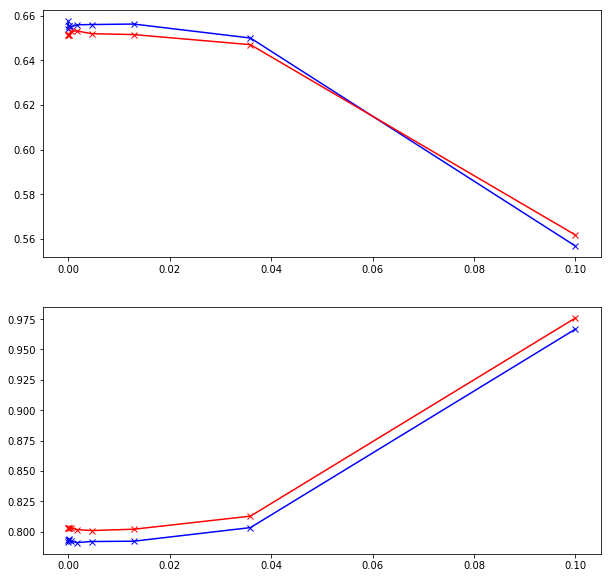

In [1127]:
f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
ax1.plot(thresholds_for_test, f1scorescv, "bx-", thresholds_for_test, f1scorestest, "rx-")
ax2.plot(thresholds_for_test, [abs(loglossescv[i]) for i in range(len(loglossescv))], "bx-", thresholds_for_test, loglossestest, "rx-")

# Select an optimum threshold
f1_thresh = np.argsort(f1scorestest)[-1]
ll_thresh = np.argsort(loglossestest)[0]

# Average the two
final_threshold = np.average((thresholds_for_test[f1_thresh], thresholds_for_test[ll_thresh]))

# final_support is now a boolean array masking out the most important features.
final_support = fselGB.feature_importances_>=final_threshold

print "Will use threshold ", final_threshold
print final_support

# Save the contents of X_test before feature reduction.
#X_test_pre_red = X_test

# Reduce the features on the training and test sets
X_train = X_train[:,final_support]
X_test = X_test[:, final_support]



Print the selected column names in order of importance. 

We can see that the features identified as expanatory in the Data Exploration section also appear here. This is expected and is a good indication that we are selecting the correct fields.

It is also interesting to see which breeds/breed features are he most important.

In [1128]:
sortedIndexes = np.argsort(fselGB.feature_importances_)[::-1]
colnames=X_train_df.columns.values
#colnames = np.append(colnames, "SimpleOutcome")

print colnames[sortedIndexes][final_support[sortedIndexes]]

['AgeDays' 'OutcomeHour' 'HasName' 'Neutered' 'AnimalType' 'OutcomeMonth'
 'OutcomeDay' 'IsWeekend' 'DaySegment_HR_2' 'AgeBracket_baby'
 'DaySegment_HR_3' 'AgeBracket_juvenile' 'Sex_female' 'PureBreed'
 u'Breed_domestic' 'DaySegment_HR_4' 'DaySegment_HR_6' u'Breed_chihuahua'
 'DaySegment_HR_0' u'Breed_rat' u'Breed_collie' u'Breed_shorthair'
 u'Breed_poodle' u'Breed_redbone' u'Breed_standard' 'Sex_male'
 u'Breed_maltese' u'Breed_manchester' 'DaySegment_HR_5']


In [934]:
from sklearn.cross_validation import StratifiedKFold
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
# We use the genetic algorithm cross validation search library at https://github.com/rsteca/sklearn-deap 
# in order to optimize the XGBoost Hyperparameters.
from evolutionary_search import EvolutionaryAlgorithmSearchCV

# Ideally we use approx. 10 folds
k_fold = 3
  
# Use Stratified KFold so as to mitigate the effects of the imbalanced dataset.
# Stratified k-fold makes sure that the cross validation folds are always selected with the same 
# ratio of outcome classes
cv = StratifiedKFold(y_train[:,0],n_folds=k_fold,shuffle=True)
  
# initialize the classifier
GB = xgb.XGBClassifier()
  
# Define the hyperparamer ranges inside which we want to optimize our model
param_grid = {'max_depth': [500],
              'learning_rate': np.arange(0.1,0.5, 0.1),
              'objective':['multi:softprob'],
              'n_jobs': [2],
              'missing': [np.nan],
              'reg_alpha': np.geomspace(3, 15, 10, endpoint=True),
              'colsample_bytree': np.arange(0.25, 0.55, 0.02),
              'colsample_bylevel': np.arange(0.45, 0.85, 0.2),
              'subsample': np.arange(0.80, 1, 0.01),
              'n_estimators': np.arange(50, 300, 20)}
  
#param_grid = {'max_depth': [500],
#              'learning_rate': np.arange(0.15, 0.25, 0.01),
#              'objective':['multi:softprob'],
#              'n_jobs': [3],
#              'missing': [np.nan],
#              'reg_alpha': np.geomspace(3, 10, 10, endpoint=True),
#              'colsample_bytree': np.arange(0.45, 0.55, 0.01),
#              'colsample_bylevel': np.arange(0.75, 0.85, 0.01),
#              'subsample': np.arange(0.85, 0.95, 0.01),
#              'n_estimators': np.arange(50, 100, 10)}

#param_grid = {'max_depth': [500],
#              'learning_rate': np.arange(0.25, 0.35, 0.02),
#              'objective':['multi:softprob'],
#              'n_jobs': [2],
#              'missing': [np.nan],
#              'reg_alpha': np.geomspace(9, 11, 10, endpoint=True),
#              'colsample_bytree': np.arange(0.25, 0.35, 0.02),
#              'colsample_bylevel': np.arange(0.45, 0.55, 0.02),
#              'subsample': np.arange(0.85, 1, 0.02),
#              'n_estimators': np.arange(90, 110, 10)}

search_GB = EvolutionaryAlgorithmSearchCV(estimator=GB,
                                   params=param_grid,
                                   scoring="neg_log_loss",
                                   cv=cv,
                                   verbose=10,
                                   population_size=50,
                                   gene_mutation_prob=0.20,
                                   gene_crossover_prob=0.5,
                                   tournament_size=5,
                                   generations_number=20,
                                   n_jobs=3)

search_GB.fit(X_train,y_train[:,0])
print ' ',search_GB.best_score_
print ' ',search_GB.best_params_



Types [1, 2, 2, 1, 2, 2, 1, 2, 2, 1] and maxint [12, 19, 9, 0, 15, 0, 0, 3, 1, 0] detected
--- Evolve in 332800 possible combinations ---
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=110, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.772543835087, total=   4.4s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_b

[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=110, subsample=0.83, objective=multi:softprob, max_depth=500, score=-0.78832298941, total=   4.8s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.33, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.81, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.31, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.91, objective=multi:softprob, max_depth=500, score=-0.782297343729, total=   6.7s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.31, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.91, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=290, subsample=0.92, objective=multi:softprob,

[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=210, subsample=0.91, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=290, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.777996966128, total=  11.6s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=290, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.810272642158, total=  15.0s
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=110, subsample=0.96, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=50, subsample=0.94, objective=multi:softprob, max_depth=500, score=-0.812455368752, total=   1.8s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=50, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=110, subsample=0.96, objective=multi:softprob, max_depth=500, score=-0.783949206768, total=   3.2s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=110, subsample=0.96, ob

[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=50, subsample=0.96, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=190, subsample=0.82, objective=multi:softprob, max_depth=500, score=-0.779372785579, total=   7.3s
[CV] reg_alpha=15.0, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=190, subsample=0.82, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=50, subsample=0.96, objective=multi:softprob, max_depth=500, score=-0.8009866054, total=   1.9s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=50, subsample=0.96, objective=multi:so

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.33, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=110, subsample=0.89, objective=multi:softprob, max_depth=500, score=-0.776630198034, total=   5.3s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.33, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=110, subsample=0.89, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.78349824913, total=   6.1s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objectiv

[CV] reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=150, subsample=0.84, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.776803427988, total=   8.4s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=110, subsample=0.82, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=190, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.785515560405, total=  10.6s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=190, subsample=0

[CV] reg_alpha=15.0, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=110, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.807932209851, total=   7.3s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=70, subsample=0.84, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=70, subsample=0.84, objective=multi:softprob, max_depth=500, score=-0.780980315482, total=   2.5s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=70, subsample=0.84, objective=multi:softprob, max_depth=500 
[CV]  r

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=170, subsample=0.84, objective=multi:softprob, max_depth=500, score=-0.789137396333, total=   6.9s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=170, subsample=0.84, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.93, objective=multi:softprob, max_depth=500, score=-0.78458778058, total=   4.9s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.93, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=150, subsample=0.83, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=110, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.783966074084, total=   5.7s
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=110, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.776104739201, total=   9.9s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.87, 

[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.779495340787, total=   5.4s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.91, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.781392927702, total=  11.2s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=70, subsample=0.

[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.86, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.86, objective=multi:softprob, max_depth=500, score=-0.778974525667, total=   4.2s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=110, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.782121178707, total=   7.4s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.8

[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.777043893665, total=   4.3s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.782192297409, total=   3.7s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.85

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=250, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=110, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.780084762765, total=   5.8s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=250, subsample=0.89, objective=multi:softprob, max_depth=500, score=-0.798705072494, total=  13.3s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=250, subsample=0.89, object

[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.91, objective=multi:softprob, max_depth=500, score=-0.782501733327, total=   7.1s
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.91, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.782684511894, total=   7.3s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.777830416165, total=   3.9s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.783474276537, total=   3.8s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.85, objec

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=130, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=130, subsample=0.94, objective=multi:softprob, max_depth=500, score=-0.77380095946, total=   7.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=130, subsample=0.94, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.781271611657, total=   4.3s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=70, subsample=0.88, o

[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.78402029942, total=   7.9s
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.776837988807, total=   7.7s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.94, objective=multi:softprob, max_depth=500, score=-0.774802347163, total=   8.8s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=110, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.776104739201, total=   9.8s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=70, subsample=0.91

[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=210, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.778883510748, total=   8.2s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=210, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.91, objective=multi:softprob, max_depth=500, score=-0.781797548951, total=   8.4s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.91, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=250, subsample=0.94, obje

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.772423674356, total=   9.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.769880384771, total=   9.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, o

[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=110, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.781387172909, total=   5.8s
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=110, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.774314250341, total=   9.3s
[CV] reg_alpha=15.0, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=170, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.89, objecti

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=110, subsample=0.91, objective=multi:softprob, max_depth=500, score=-0.782922780209, total=   6.0s
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=110, subsample=0.91, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.783546900078, total=   6.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.789910939634, total=   8.0s
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.772423674356, total=   7.3s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, 

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.33, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500, score=-0.773199024308, total=   9.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.33, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.84, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.33, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.787894321324, total=   4.8s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.33, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=130, subsample=0.95, 

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=230, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.779007035902, total=  15.3s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=230, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.771927436661, total=   8.6s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=90, subsample=0.89, ob

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=190, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.778841044945, total=   9.6s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.778522170312, total=   9.0s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, 

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500, score=-0.778778225223, total=   9.5s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=290, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.780183196783, total=  19.5s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=290, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92,

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.91, objective=multi:softprob, max_depth=500, score=-0.774823104074, total=   9.4s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=230, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.84, objective=multi:softprob, max_depth=500, score=-0.77191640184, total=   9.9s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.84, o

[CV]  reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.779117794106, total=   6.0s
[CV] reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500, score=-0.773199024308, total=   9.1s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.94, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=130, subsample=0.

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.84, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=290, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.777277385265, total=  21.2s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=70, subsample=0.83, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.772423674356, total=   9.9s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, obj

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.777940397007, total=   9.1s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.777940397007, total=   9.2s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=mul

[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500, score=-0.773572418741, total=   8.1s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.777940397007, total=   9.8s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.96,

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.777747990045, total=   8.9s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.777940397007, total=   9.5s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, ob

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.99, objective=multi:softprob, max_depth=500, score=-0.778297879215, total=   9.1s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.99, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.784715521587, total=   9.2s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.97,

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.770196174495, total=   9.8s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.771106543645, total=   9.2s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, obj

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.770196174495, total=   9.8s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.1s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, ob

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.97, objective=multi:softprob, max_depth=500, score=-0.772733129439, total=   9.7s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.771446794802, total=   9.9s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.97, ob

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.774314250341, total=   9.8s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.97, objective=multi:softprob, max_depth=500, score=-0.76990051948, total=   9.3s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.97, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=130, subsample=0.99, o

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.770196174495, total=   9.5s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.91, objective=multi:softprob, max_depth=500, score=-0.777680372293, total=   8.9s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.91, ob

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.771446794802, total=   9.5s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.771504242276, total=   9.5s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.97, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.98, 

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=90, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775721930082, total=   7.3s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=90, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.789848449745, total=   6.1s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=90, subsample=0.9, object

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.97, objective=multi:softprob, max_depth=500, score=-0.772733129439, total=   9.0s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98,

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.97, objective=multi:softprob, max_depth=500, score=-0.776735834671, total=   9.3s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.97, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.97, objective=multi:softprob, max_depth=500, score=-0.76990051948, total=   9.1s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.97, o

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.773075577016, total=  15.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.3s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95,

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   8.9s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=170, subsample=0.83, objective=multi:softprob, max_depth=500, score=-0.776718416162, total=   9.9s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98,

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
11 	31    	-0.772591	-0.783945	-0.772021	0.00196705 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   8.8s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, 

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   9.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.1s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, 

[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.786085833843, total=   6.2s
[CV] reg_alpha=15.0, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.6s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softpro

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=110, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.771504242276, total=   8.9s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.771504242276, total=  10.0s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.98,

[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.783711362924, total=   7.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   9.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=170, subsample=0.98

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.771504242276, total=  10.0s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   8.9s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, o

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.771504242276, total=   9.3s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   9.3s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:s

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.782392700545, total=   7.4s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.771504242276, total=  10.0s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=130, subsample=0.98

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.3s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.771504242276, total=   9.7s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98,

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   9.1s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   9.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, 

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.3s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=270, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.826833986692, total=  17.0s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=270, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98,

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500, score=-0.781282701485, total=   8.1s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.771504242276, total=   9.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98,

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.771504242276, total=   9.6s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.781761722648, total=   7.2s
[CV] reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=270, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   9.7s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   9.2s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, 

[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.774717219744, total=  16.4s
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.2s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.9

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   8.7s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=170, subsample=0.84, objective=multi:softprob, max_depth=500, score=-0.780514506192, total=   8.9s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98,

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.2s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   9.7s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98,

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.1s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, 

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.78364924873, total=   8.8s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.786105099239, total=   5.8s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, 

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.797946750906, total=  13.5s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.775579928169, total=   9.0s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.771504242276, total=  10.0s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.81, objective=multi:softprob, max_depth=500, score=-0.773589282964, total=   8.7s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.81, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.98,

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=230, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.778201312097, total=  11.8s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.78364924873, total=   8.9s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, 

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
19 	28    	-0.772764	-0.780929	-0.772021	0.00217526 
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   9.2s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, 

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   9.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.768979899078, total=   9.7s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.98, 

In [935]:
print search_GB.best_score_
print search_GB.best_params_

-0.772021144584
{'reg_alpha': 3.5874395235012058, 'n_jobs': 2, 'colsample_bytree': 0.49000000000000021, 'missing': nan, 'learning_rate': 0.10000000000000001, 'colsample_bylevel': 0.65000000000000002, 'n_estimators': 130, 'subsample': 0.9800000000000002, 'objective': 'multi:softprob', 'max_depth': 500}


Finally initialise our final model with optimized hyperparameters, train it with the selected features and generate predictions and probabilities for the test set.

In [936]:
from numpy import nan
from numpy import sort
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

#Best hyperparameters found for ds w/o PCA
params={'reg_alpha': 3.5874395235012058, 'n_jobs': 2, 'colsample_bytree': 0.49000000000000021, 'missing': nan, 'learning_rate': 0.10000000000000001, 'colsample_bylevel': 0.65000000000000002, 'n_estimators': 130, 'subsample': 0.9800000000000002, 'objective': 'multi:softprob', 'max_depth': 500}

#Best hyperparameters foud for ds w/ PCA
#params={'reg_alpha': 6.1344352953443737, 'n_jobs': 2, 'colsample_bytree': 0.51000000000000023, 'missing': nan, 'learning_rate': 0.10000000000000001, 'colsample_bylevel': 0.65000000000000002, 'n_estimators': 130, 'subsample': 0.92000000000000015, 'objective': 'multi:softprob', 'max_depth': 500}

GB = xgb.XGBClassifier(**search_GB.best_params_)

GB.fit(X_train, y_train[:,0])

preds = GB.predict(X_test)

proba = GB.predict_proba(X_test)

print preds
print proba


[0 3 0 ..., 3 0 0]
[[ 0.94111955  0.00818344  0.00998116  0.01185678  0.02885903]
 [ 0.20517239  0.00255142  0.03672126  0.38315624  0.37239873]
 [ 0.78327394  0.01372833  0.02778102  0.02272139  0.15249531]
 ..., 
 [ 0.14173447  0.00336114  0.04024224  0.61133265  0.20332956]
 [ 0.85408157  0.00469658  0.01782621  0.01047057  0.11292511]
 [ 0.97407204  0.00128623  0.0029051   0.00769404  0.01404264]]


Calculate performance metrics for our test set predictions.

In [937]:

from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

f1score = f1_score(y_test, preds, average="micro")
logloss = log_loss(y_test, proba, labels=GB.classes_)
print "f1 score=", f1score
print "log loss=", logloss

f1 score= 0.68125701459
log loss= 0.780813659174


Plot ROC curves for prediction performance for our outcome classes.

3 2


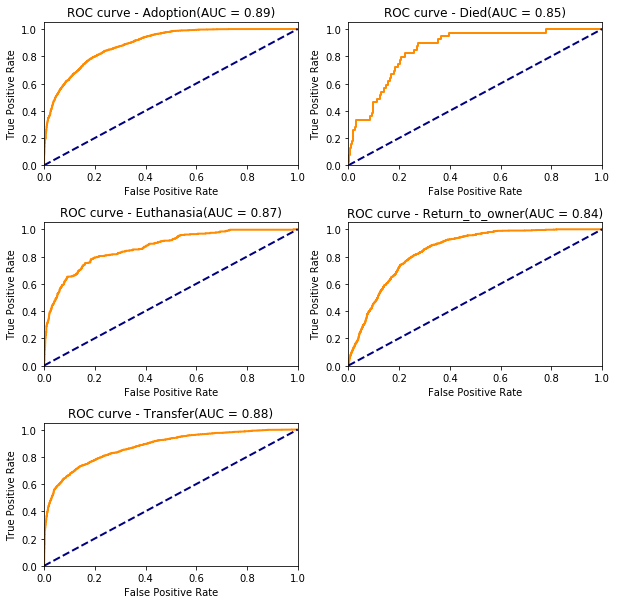

In [938]:
y_test_bin = label_binarize(y_test[:,0], GB.classes_)
plotROCCurves(GB.classes_, labelMapper.features[0][1].inverse_transform(GB.classes_), y_test_bin, proba)

Also generate a confusion matrix for the predictions.

In [939]:
from sklearn.metrics import confusion_matrix
print labelMapper.features[0][1].inverse_transform(GB.classes_)
cm = confusion_matrix(y_test[:,0], preds)#y_train[:,0]
cm


['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']


array([[1743,    0,    1,  237,  173],
       [   5,    1,    3,    4,   26],
       [  48,    1,   59,   62,  141],
       [ 333,    0,    2,  487,  135],
       [ 308,    1,   20,  204, 1352]])

In [940]:
X_full, y_full = prepareDFForPrediction(df, df[["OutcomeType"]])

    
GB.fit(X_full.values[:,final_support], y_full.values[:,0])

splitSex...
cleanupBreed...
processBreed...
(26729, 262)
processAge...
processDate...
processWeekend...
processName...
processColor...


XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.65000000000000002,
       colsample_bytree=0.49000000000000021, gamma=0,
       learning_rate=0.10000000000000001, max_delta_step=0, max_depth=500,
       min_child_weight=1, missing=None, n_estimators=130, n_jobs=2,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=3.5874395235012058, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9800000000000002)

In [941]:
testdf = pd.read_csv("test.csv")

testdf, y = prepareDFForPrediction(testdf)

testdf.head()


splitSex...
cleanupBreed...
processBreed...
(11456, 262)
processAge...
processDate...
processWeekend...
processName...
processColor...


,AnimalType,Sex_female,Sex_male,Neutered,PureBreed,AgeBracket_adult,AgeBracket_baby,AgeBracket_juvenile,DaySegment_HR_0,DaySegment_HR_1,...,Breed_whippet,Breed_wire,Breed_wirehair,Breed_wirehaired,Breed_wolfhound,Breed_yorkshire,AgeDays,OutcomeDay,OutcomeMonth,OutcomeHour
0,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,300,12,10,12
1,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,730,26,7,17
2,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,365,13,1,12
3,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,120,28,12,18
4,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,730,24,9,17


In [942]:
X_kaggle_test = testdf.loc[:, testdf.columns!="ID"].values
print testdf.shape 
for c in testdf.columns.values:
    print c
    
preds = GB.predict(X_kaggle_test[:,final_support])
probs = GB.predict_proba(X_kaggle_test[:,final_support])
print GB.classes_
print labelMapper.features[0][1].inverse_transform(GB.classes_)
results = np.concatenate((testdf[["ID"]].values, probs), axis=1)
resultsdf = pd.DataFrame(results, columns=["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
resultsdf["ID"] = resultsdf["ID"].astype(int)
resultsdf.to_csv("results3csv", index=False)
resultsdf

(11456, 285)
AnimalType
Sex_female
Sex_male
Neutered
PureBreed
AgeBracket_adult
AgeBracket_baby
AgeBracket_juvenile
DaySegment_HR_0
DaySegment_HR_1
DaySegment_HR_2
DaySegment_HR_3
DaySegment_HR_4
DaySegment_HR_5
DaySegment_HR_6
DaySegment_HR_7
IsWeekend
HasName
ID
Breed_abyssinian
Breed_affenpinscher
Breed_afghan
Breed_airedale
Breed_akita
Breed_alaskan
Breed_american
Breed_anatol
Breed_angora
Breed_apso
Breed_argentino
Breed_australian
Breed_balinese
Breed_basenji
Breed_basset
Breed_bay
Breed_beagle
Breed_bearded
Breed_beauceron
Breed_bedlington
Breed_belgian
Breed_bengal
Breed_bernard
Breed_bernese
Breed_bichon
Breed_black
Breed_bloodhound
Breed_blue
Breed_bluetick
Breed_bobtail
Breed_boerboel
Breed_bombay
Breed_bordeaux
Breed_border
Breed_borzoi
Breed_boston
Breed_boxer
Breed_boykin
Breed_brindle
Breed_british
Breed_brittany
Breed_brown
Breed_bruss
Breed_bull
Breed_bulldog
Breed_bullmastiff
Breed_burmese
Breed_cairn
Breed_canaan
Breed_canario
Breed_cane
Breed_cardigan
Breed_carolina

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.0244109,0.00196376,0.0490864,0.135251,0.789288
1,2,0.700607,0.00121665,0.016181,0.237614,0.0443816
2,3,0.374981,0.00322431,0.0268175,0.247667,0.347311
3,4,0.285653,0.0101672,0.0457837,0.239288,0.419108
4,5,0.575157,0.001236,0.0126738,0.334221,0.0767126
5,6,0.232764,0.00214727,0.0492513,0.55863,0.157208
6,7,0.196867,0.0657836,0.491152,0.149456,0.0967417
7,8,0.854378,0.0111603,0.0126573,0.015715,0.10609
8,9,0.835784,0.00118211,0.00358854,0.100419,0.0590264
9,10,0.635887,0.00117485,0.0142981,0.294843,0.0537978
